# __Modeling__

## __Springboard Data Science Course Capstone Project 2__
#### __Ben Takacs__

#### __Imports__

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy
import sklearn as sc
import sklearn.metrics as metrics

import lightgbm as lgb
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from functools import partial
# from catboost import CatBoostClassifier, cv, ProcessLookupError


#### __Load Data__

In [30]:
path = './data/'
# df = pd.read_csv(path + 'df_cleaned.csv')
df_features = pd.read_csv(path + 'df_features.csv')
df_target = pd.read_csv(path + 'df_target.csv')

Xtrain = pd.read_csv(path + 'Xtrain.csv')
Xtest = pd.read_csv(path + 'Xtest.csv')
ytrain = pd.read_csv(path + 'ytrain.csv')
ytest = pd.read_csv(path + 'ytest.csv')


In [31]:
if df_features.shape[0] == df_target.shape[0]:
    print('Data Loaded Successfully')
else:
    print('Data Loading Failed')

Data Loaded Successfully


In [32]:
# Load dictionaries from dict_file.txt and replace string keys with int values
with open('./data/dict_file.txt', 'r') as file:
    for line in file:
        split = line.split(' ', maxsplit=2)
        globals()[split[0]] = eval(split[2])
        globals()[split[0]] = {int(k):v for k, v in globals()[split[0]].items()}

# Test that we have the dictionaries loaded correctly
print(mothers_occupation)

{0: 'Student', 1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers', 2: 'Specialists in Intellectual and Scientific Activities', 3: 'Intermediate Level Technicians and Professions', 4: 'Administrative staff', 5: 'Personal Services, Security and Safety Workers and Sellers', 6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry', 7: 'Skilled Workers in Industry, Construction and Craftsmen', 8: 'Installation and Machine Operators and Assembly Workers', 9: 'Unskilled Workers', 10: 'Armed Forces Professions', 90: 'Other Situation', 99: '(blank)', 122: 'Health professionals', 123: 'teachers', 125: 'Specialists in information and communication technologies (ICT)', 131: 'Intermediate level science and engineering technicians and professions', 132: 'Technicians and professionals, of intermediate level of health', 134: 'Intermediate level technicians from legal, social, sports, cultural and similar services', 141: 'Offic

## __Model 1: Random Forest__

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300, random_state=10
)
model_rf = rf.fit(Xtrain, ytrain)

ypred_rf = model_rf.predict(Xtest)
ypred_prob_rf = model_rf.predict_proba(Xtest)
lr_prob_rf = ypred_prob_rf[:,1]
ac = metrics.accuracy_score(ytest, ypred_rf)
f1 = metrics.f1_score(ytest, ypred_rf, average='weighted')

print('Random Forest: Accuracy Score: %.3f' % (ac))
print('Random Forest: F1 Score: %.3f' % (f1))

/var/folders/qj/vjvpkp3d3rq87m_14mc70r_00000gn/T/ipykernel_48524/3888553391.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf = rf.fit(Xtrain, ytrain)


Random Forest: Accuracy Score: 0.906
Random Forest: F1 Score: 0.905


Our accuracy and F1 scores look pretty good, let's look at the ROC curve.

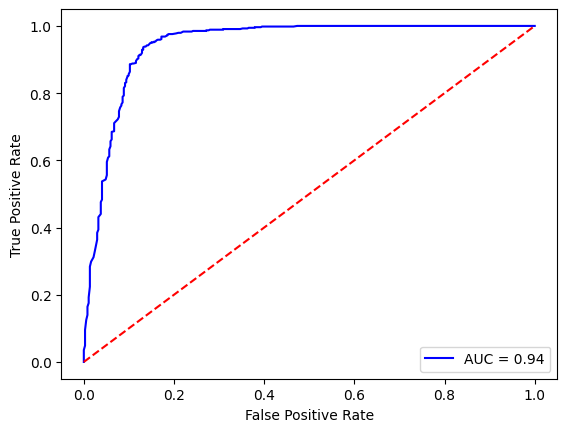

In [34]:
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(ytest, ypred_prob_rf[:,1], pos_label='Graduate')

roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC curve also looks good, we want the blue line to stick to the top left corner as much as possible.

##### __Feature Importance__

<AxesSubplot:>

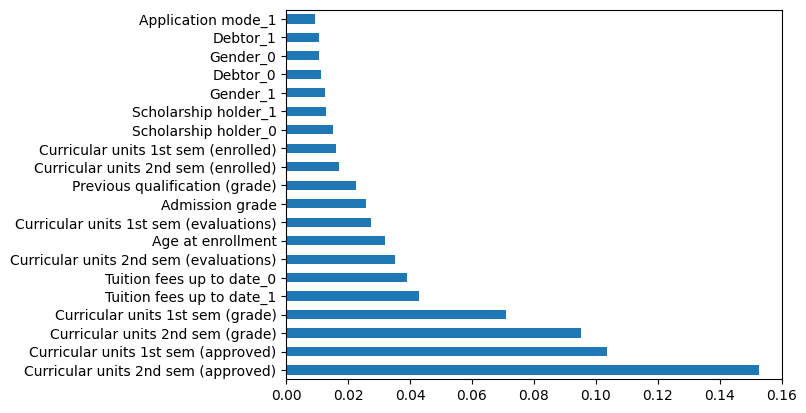

In [35]:
#Cool method chaining
pd.Series(rf.feature_importances_, index=df_features.columns).nlargest(20).plot(kind='barh')

From the feature importance we see that the number of curricular units 

## __Model 2: Gradient Boosted Decision Tree__

In [36]:
# Find best learning rate for model
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = sc.ensemble.GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=10, max_depth = 10, random_state = 0)
    gb.fit(Xtrain, ytrain)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(Xtrain, ytrain)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(Xtest, ytest)))
    print()

/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.05
Accuracy score (training): 0.941
Accuracy score (validation): 0.887

Learning rate:  0.1


/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score (training): 0.961
Accuracy score (validation): 0.902

Learning rate:  0.25
Accuracy score (training): 0.986
Accuracy score (validation): 0.910



/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.5
Accuracy score (training): 0.995
Accuracy score (validation): 0.895

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.887



/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.868



/Users/bencetakacs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9096916299559471


<Figure size 640x480 with 0 Axes>

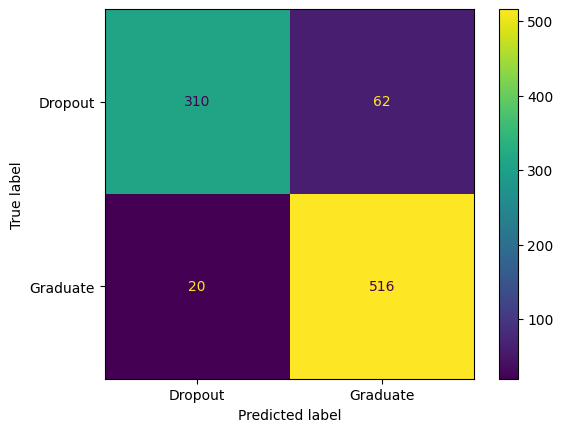

In [37]:
gb = sc.ensemble.GradientBoostingClassifier(
    n_estimators=20, learning_rate=0.25, max_features=10, max_depth=10, random_state=0
)
gb.fit(Xtrain, ytrain)
ypred_gb = gb.predict(Xtest)

score = gb.score(Xtest, ytest)
print(score)

plt.figure()
cm = metrics.confusion_matrix(ytest, ypred_gb, labels=gb.classes_)
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dropout', 'Graduate'])
display_cm.plot()
plt.show()

91% is not a bad score, and we can see that it predicts dropouts better than graduates. It is more likely to predict a dropout student as graduating than a graduate student as dropping out, an optimistic model.

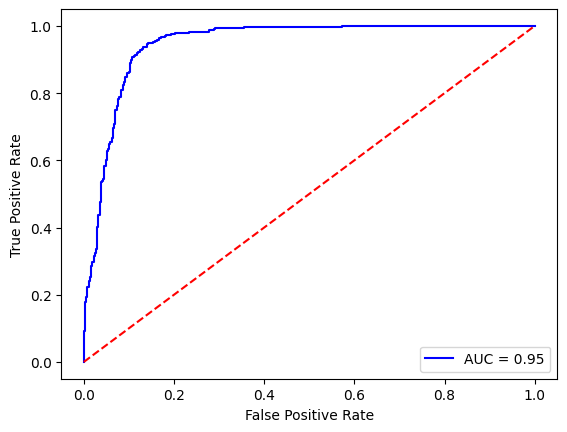

In [38]:
yprob_gb = gb.predict_proba(Xtest)[:,1]

fpr_gb, tpr_gb, threshold = metrics.roc_curve(ytest, yprob_gb, pos_label='Graduate')
roc_auc_gb = metrics.auc(fpr_gb, tpr_gb)

plt.plot(fpr_gb, tpr_gb, 'b', label = 'AUC = %0.2f' % roc_auc_gb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

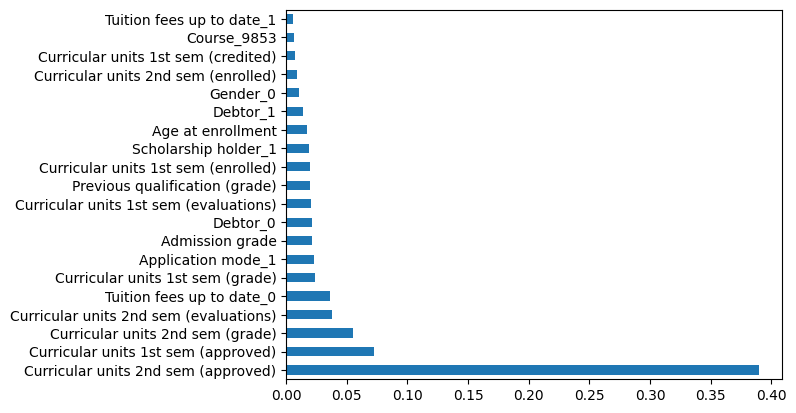

In [92]:
feat_importances = pd.Series(gb.feature_importances_, index=df_features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Like the first model, the gradient boosted model finds curricular units and tuition fees status very important.

## __Model 3: Entropy Decision Tree Model__

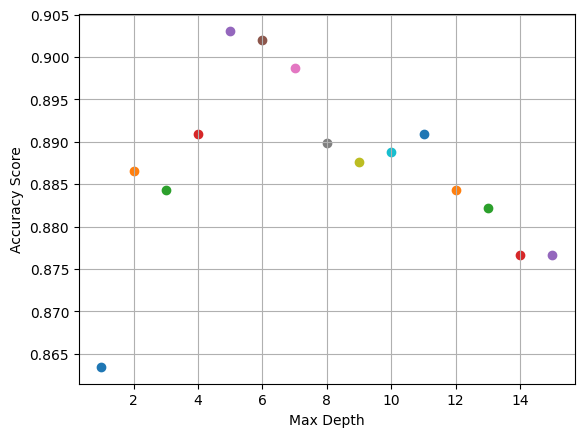

In [40]:
plt.figure()

l = 16
array = np.zeros(l)
criterion = 'gini'
for i in range(1, l):
    dtc = sc.tree.DecisionTreeClassifier(criterion=criterion, max_depth=i, random_state=10)

    dtc.fit(Xtrain, ytrain)
    ypred_en = dtc.predict(Xtest)

    ypred_en = pd.Series(ypred_en)
    plt.scatter(i, metrics.accuracy_score(ytest,ypred_en))
    array[i] = metrics.accuracy_score(ytest,ypred_en)

plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

For increasing max_depth, the model performs worse after reaching a max accuracy score at max_depth = 4, so that's what we can choose for our max depth.

In [41]:
dtc = sc.tree.DecisionTreeClassifier(
    criterion=criterion, max_depth=np.argmax(array), random_state=10, 
)

dtc.fit(Xtrain, ytrain)
ypred_gi = dtc.predict(Xtest)

ypred_gi = pd.Series(ypred_gi)

print("Model Entropy - max depth = %.i" % dtc.max_depth)
print("Accuracy:", metrics.accuracy_score(ytest,ypred_gi))
print("Balanced accuracy:", metrics.balanced_accuracy_score(ytest,ypred_gi))
print('Precision score for "Graduate"' , metrics.precision_score(ytest,ypred_gi, pos_label = "Graduate"))
print('Precision score for "Dropout"' , metrics.precision_score(ytest,ypred_gi, pos_label = "Dropout"))
print('Recall score for "Graduate"' , metrics.recall_score(ytest,ypred_gi, pos_label = "Graduate"))
print('Recall score for "Dropout"' , metrics.recall_score(ytest,ypred_gi, pos_label = "Dropout"))

Model Entropy - max depth = 5
Accuracy: 0.9030837004405287
Balanced accuracy: 0.8891229337185043
Precision score for "Graduate" 0.8809523809523809
Precision score for "Dropout" 0.94375
Recall score for "Graduate" 0.9664179104477612
Recall score for "Dropout" 0.8118279569892473


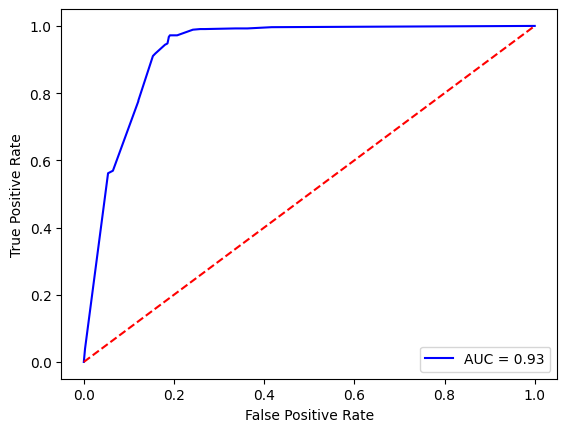

In [42]:
yprob_gi = dtc.predict_proba(Xtest)[:,1]

fpr_gi, tpr_gi, threshold = metrics.roc_curve(ytest, yprob_gi, pos_label='Graduate')
roc_auc_gi = metrics.auc(fpr_gi, tpr_gi)

plt.plot(fpr_gi, tpr_gi, 'b', label = 'AUC = %0.2f' % roc_auc_gi)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This roc curve is slightly worse than those of the previous 2 models, but still very good.

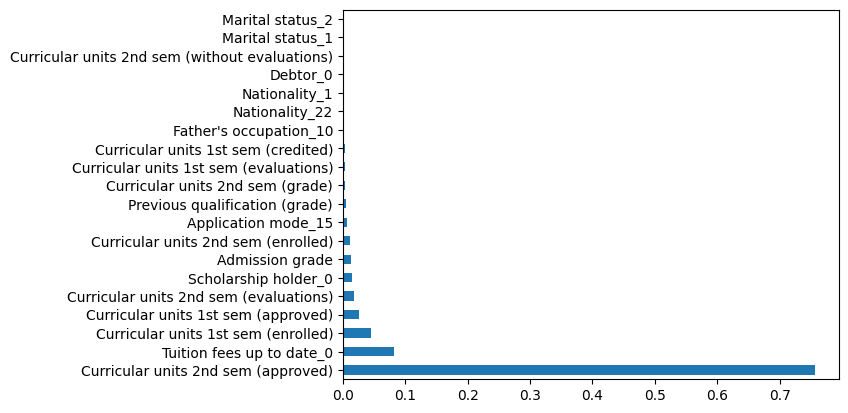

In [93]:
feat_importances = pd.Series(dtc.feature_importances_, index=df_features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Interestingly, with this model the specific curricular units 2nd semester approved is extremely important, much more so than any other feature, whereas the previous models had at least a couple numbers of curricular units placed at a relatively high importance./

In [44]:
application_mode[15]

'International student (bachelor)'

## __Model 4: LightGBM__

Light gradiant boosted model

In [47]:
# Convert y data to booleans, True = Graduate, False = Dropout
ytrainb = ytrain.replace(to_replace=['Graduate', 'Dropout'], value=[1, 0])
ytestb = ytest.replace(to_replace=['Graduate', 'Dropout'], value=[1, 0])

In [ ]:
train_data = lgb.Dataset(Xtrain, label=ytrainb)
test_data = lgb.Dataset(Xtest, label=ytestb)

params = {
    'objective':'binary',
    # 'num_class':2,
    'metric':'auc',
    'verbosity':0,
    'seed':42
}

num_round = 100
clf = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=10)

y_pred = clf.predict(Xtest)
accuracy = metrics.accuracy_score(ytestb, np.round(y_pred, 0))
print(f'Accuracy: {accuracy}')

/Users/bencetakacs/thesis/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	valid_0's auc: 0.934443
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.935143
[3]	valid_0's auc: 0.935328
[4]	valid_0's auc: 0.938052
[5]	valid_0's auc: 0.936394
[6]	valid_0's auc: 0.937851
[7]	valid_0's auc: 0.939045
[8]	valid_0's auc: 0.940354
[9]	valid_0's auc: 0.93984
[10]	valid_0's auc: 0.940815
[11]	valid_0's auc: 0.942272
[12]	valid_0's auc: 0.942618
[13]	valid_0's auc: 0.944519
[14]	valid_0's auc: 0.944551
[15]	valid_0's auc: 0.945023
[16]	valid_0's auc: 0.945249
[17]	valid_0's auc: 0.945442
[18]	valid_0's auc: 0.946532
[19]	valid_0's auc: 0.947029
[20]	vali

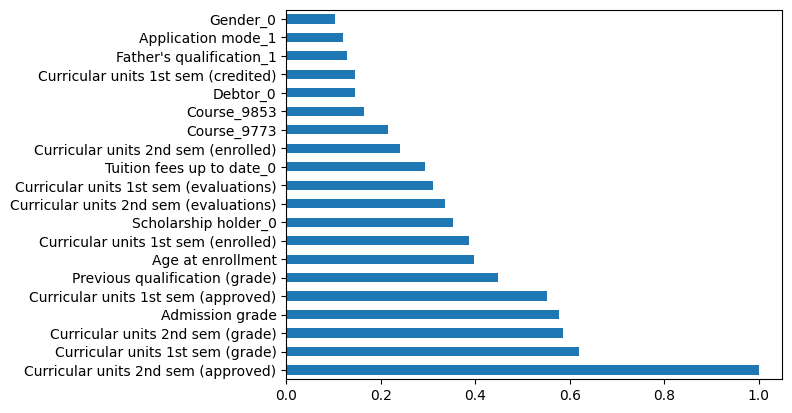

In [91]:
feat_importances = pd.Series(clf.feature_importance()/clf.feature_importance().max(), index=df_features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Similar to other models, the number of curricular units is basically what determines the academic result of the studnet, althoguth admission grade and previout qualification are also important.

## __Model 5: Bayesian Optimizaed Features__

In [ ]:
classifier = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    n_estimators=10,
    learning_rate=0.03,
    num_leaves=4000,
    random_state=10
)

search_space = {
    'learning_rate':Real(0.01, 1.0, 'log-uniform'),
    'n_estimators':Integer(30,5000),
    'num_leaves':Integer(2, 512),
    'max_depth':Integer(-1, 256),
    'min_child_samples':Integer(1, 256),
    'max_bin':Integer(100, 1000),
    'subsample':Real(0.01, 1.0, 'uniform'),
    'subsample_freq':Integer(0, 10),
    'colsample_bytree':Real(0.01, 1.0, 'uniform'),
    'min_child_weight':Real(0.01, 10.0, 'uniform'),
    'reg_lambda':Real(1e-9, 100.0, 'log-uniform'),
    'reg_alpha':Real(1e-9, 100.0, 'log-uniform'),
}

kf = sc.model_selection.KFold(n_splits=5, shuffle=True, random_state=10)

In [ ]:
ytrainb = np.array(ytrainb)
ytrainb = ytrainb[:,0]

(2722,)


In [67]:
opt = BayesSearchCV(
    estimator=classifier,
    search_spaces=search_space,
    n_iter=50,
    cv=kf,
    random_state=10,
    iid=False,
    verbose=0,
)

_ = opt.fit(Xtrain, ytrainb)

/Users/bencetakacs/thesis/lib/python3.8/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(


In [79]:
print('Score {:.4f}\nBest Params: {}'.format(opt.score(Xtest, ytestb), opt.best_params_))

Score 0.9086
Best Params: OrderedDict([('colsample_bytree', 0.8232826842387748), ('learning_rate', 0.010025832296086752), ('max_bin', 492), ('max_depth', 52), ('min_child_samples', 1), ('min_child_weight', 1.8152323127483947), ('n_estimators', 3952), ('num_leaves', 126), ('reg_alpha', 1e-09), ('reg_lambda', 5.056245134673608e-08), ('subsample', 0.6138764486219696), ('subsample_freq', 7)])


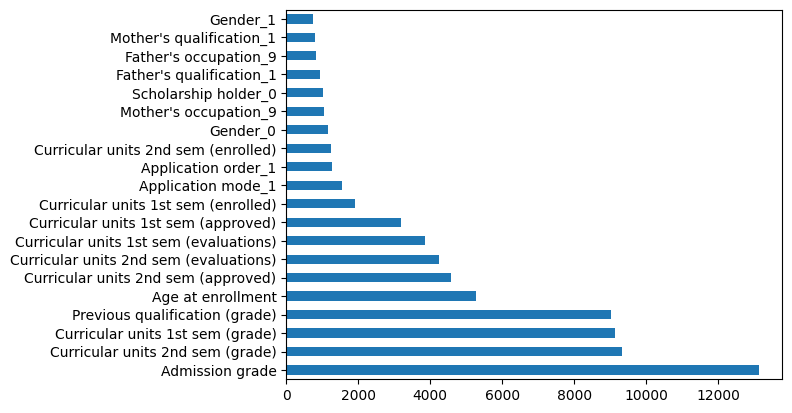

In [94]:
feat_importances = pd.Series(opt.best_estimator_.feature_importances_, index=df_features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

This model places admission grade as the top predictor, which is more in line with what we saw in the EDA portion of the analysis.